In [3]:
import json
import pandas as pd
import numpy as np
from pandas import DataFrame
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy.distance import great_circle

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import json # library to handle JSON files

import requests # library to handle requests
from requests import get

from bs4 import BeautifulSoup

import re

from time import sleep

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import seaborn as sns

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# import k-means from clustering stage
from sklearn.cluster import KMeans
print("imported")

imported


In [5]:
#This link has population projection data of different Local  Goverment Area (LGA) of New South Wales (NSW) state of Australia 
link ="https://www.planning.nsw.gov.au/-/media/Files/DPE/Other/Research-and-demography/Population-Projections/2019-NSW-Population-Projections-ASGS-2019-LGA.xlsx"
data = pd.read_excel(link, sheet_name='LGA population projections')
data.head(30)
#drop all the data with with NaN values 
data = data.dropna()
data.head()


,NSW 2019 Population Projections,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
4,ASGS 2019 LGA,2016.0,2021.0,2026.0,2031.0,2036.0,2041.0
5,Albury (C),52171.0,54374.0,56490.0,58159.0,59440.0,60383.0
6,Armidale Regional (A),30313.0,32736.0,35226.0,36486.0,37439.0,38124.0
7,Ballina (A),42993.0,44237.0,45364.0,46248.0,46835.0,47092.0
8,Balranald (A),2330.0,2437.0,2552.0,2764.0,2975.0,3185.0


In [6]:

# Create columns for the Data Frame. SyndeySuburb has the names of different LGAs
data.columns = ['SydneySuburb', '2016', '2021', '2026','2031','2036','2041']
df_SydSub=data

#get rid of redundant sympbols such as (A),(C) etc from the data
list_sydSuburb1 = df_SydSub['SydneySuburb'].to_list()
list_sydSuburb2 = list()

symbol = " ("

for  i in range(len(list_sydSuburb1)) :
    firstVal= (list_sydSuburb1[i])
    indexOfSymbol = (firstVal.find(symbol)) 
    extractedVal = firstVal[:indexOfSymbol]
    list_sydSuburb2.append(extractedVal)
    i += i
#list_NswLga2.append(extractedVal+str(i))
#convert to dataframe

df_SydSubName = DataFrame(list_sydSuburb2,columns=['SydneySuburb'])

df_SydSub['SydneySuburb'] = df_SydSubName['SydneySuburb']

df_SydSub.head()



,SydneySuburb,2016,2021,2026,2031,2036,2041
4,Balranald,2016.0,2021.0,2026.0,2031.0,2036.0,2041.0
5,Bathurst Regional,52171.0,54374.0,56490.0,58159.0,59440.0,60383.0
6,Bayside,30313.0,32736.0,35226.0,36486.0,37439.0,38124.0
7,Bega Valley,42993.0,44237.0,45364.0,46248.0,46835.0,47092.0
8,Bellingen,2330.0,2437.0,2552.0,2764.0,2975.0,3185.0


In [ ]:
df_SydSub.shape

In [7]:
#These are the name of LGAs which will be subjected to analysis for property investment advise

df_selected_Subrub = pd.DataFrame({
   'SydneySuburb':['Sydney','Camden','Blacktown','Liverpool','Parramatta']
})

df_selected_Subrub.head()



,SydneySuburb
0,Sydney
1,Camden
2,Blacktown
3,Liverpool
4,Parramatta


In [8]:
#filtering out the predicted population projection of the selected LGAs from the database 
df_popTrend = pd.merge(df_SydSub, df_selected_Subrub, on='SydneySuburb',how='inner')
df_popTrend.head(10)


,SydneySuburb,2016,2021,2026,2031,2036,2041
0,Blacktown,164534.0,198945.0,220879.0,229397.0,228720.0,234613.0
1,Camden,18114.0,17272.0,16459.0,15580.0,14635.0,13641.0
2,Liverpool,37694.0,43768.0,48429.0,48497.0,48218.0,49362.0
3,Parramatta,265468.0,269596.0,275246.0,281802.0,288431.0,296625.0
4,Sydney,20558.0,20188.0,19746.0,19169.0,18453.0,17619.0


In [9]:
#calcualte the percentage(%) increase or decrease of population  from 2016-2041
df_popTrend['%Increase/Decrease'] = round((((df_popTrend['2041']-df_popTrend['2016'])/df_popTrend['2016'])*100),2)

#arrange them in the order of top values first 
df_popTrend = df_popTrend.sort_values("%Increase/Decrease", ascending = False)

In [10]:
df_popTrend.head(10)

,SydneySuburb,2016,2021,2026,2031,2036,2041,%Increase/Decrease
0,Blacktown,164534.0,198945.0,220879.0,229397.0,228720.0,234613.0,42.59
2,Liverpool,37694.0,43768.0,48429.0,48497.0,48218.0,49362.0,30.95
3,Parramatta,265468.0,269596.0,275246.0,281802.0,288431.0,296625.0,11.74
4,Sydney,20558.0,20188.0,19746.0,19169.0,18453.0,17619.0,-14.30
1,Camden,18114.0,17272.0,16459.0,15580.0,14635.0,13641.0,-24.69


In [11]:

#These three locations have the latitude and longitude values of differnt LGAs of Australia
df_lga1 = pd.read_html("https://www.latlong.net/category/towns-14-55.html")[0]
df_lga2 = pd.read_html("https://www.latlong.net/category/towns-14-55-2.html")[0]
df_lga3 = pd.read_html("https://www.latlong.net/category/cities-14-15.html")[0]

#merging the data from three sources
frames = [df_lga1,df_lga2,df_lga3]
df_CityLocation = pd.concat(frames)
df_CityLocation.rename(columns={'Place Name':'SydneySuburb'
                          }, 
                 inplace=True)

df_CityLocation['SydneySuburb'].to_list()

list_lgaName1 = df_popTrend['SydneySuburb'].to_list()

list_lgaName2 = []

for  i in range(len(list_lgaName1)) :
    firstVal= (list_lgaName1[i]).split(',')[0]
    list_lgaName2.insert(i,firstVal)
    i += 1

df_firstName = DataFrame(list_lgaName2,columns=['SydneySuburb']) 
df_CityLocation['SydneySuburb']=df_firstName
df_CityLocation = df_CityLocation.dropna()

#this data frame the names of LGAs of NSW with their latitudes and logitudes
df_CityLocation.head(10)


,SydneySuburb,Latitude,Longitude
0,Blacktown,-41.161388,146.234451
1,Liverpool,-35.708057,150.174438
2,Parramatta,-28.643057,153.615005
3,Sydney,-33.861111,121.891945
4,Camden,-31.948999,115.827003
0,Blacktown,-33.942173,151.101456
1,Liverpool,-33.751064,150.852631
2,Parramatta,-30.090109,145.937546
3,Sydney,-29.464411,149.845108
4,Camden,-28.085995,153.422348


In [12]:
#merge location table with selected suburb table
df_popTrend_location = pd.merge(df_popTrend, df_CityLocation, on='SydneySuburb',how='inner')

#remove duplicate records
df_popTrend_location_distict =df_popTrend_location.drop_duplicates(subset='SydneySuburb',keep='last')
df_popTrend_location_distict.head(15)

,SydneySuburb,2016,2021,2026,2031,2036,2041,%Increase/Decrease,Latitude,Longitude
2,Blacktown,164534.0,198945.0,220879.0,229397.0,228720.0,234613.0,42.59,-31.083332,150.916672
5,Liverpool,37694.0,43768.0,48429.0,48497.0,48218.0,49362.0,30.95,-35.353333,149.234161
8,Parramatta,265468.0,269596.0,275246.0,281802.0,288431.0,296625.0,11.74,-33.758011,150.705444
11,Sydney,20558.0,20188.0,19746.0,19169.0,18453.0,17619.0,-14.30,-32.916668,151.750000
14,Camden,18114.0,17272.0,16459.0,15580.0,14635.0,13641.0,-24.69,-33.920921,150.923141


In [13]:
!conda install -c conda-forge geopy --yes  
from geopy.geocoders import Nominatim 

!conda install -c conda-forge folium=0.5.0 --yes
import folium

print('Folium installed and imported!')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Folium installed and imported!


In [14]:
# The selected LGAs falls under Sydney metropolital area (MPA) so get teh map of Sydney MPA on which the location of 
# selected LGAs will be plotted


#Latitude and loingitude  of Sydney
latitude = -33.7668
longitude = 150.9053

# create map and display it
SydneyMPA_map = folium.Map(location=[latitude, longitude], zoom_start=10
                    )

# display the map of Syndey MPA
SydneyMPA_map

In [16]:
#On closer inspection of the data it was relvealed that the location data we got earlier from the loaction website 
#are not 100% perfect hence get the correct location from other source and populate them maunally

df_selSuburbWithLoc = pd.DataFrame({
  
  'SydneySuburb': ['Parramatta', 'Blacktown', 'Liverpool', 'Camden', 'Sydney'],
   'Latitude':[-33.8136,-33.7668,-33.9286,-34.0544,-33.8688],
   'Longitude':[151.0034,150.9053,150.9180,150.6958,151.2093]

})


df_selSuburbWithLoc.head()


,SydneySuburb,Latitude,Longitude
0,Parramatta,-33.8136,151.0034
1,Blacktown,-33.7668,150.9053
2,Liverpool,-33.9286,150.9180
3,Camden,-34.0544,150.6958
4,Sydney,-33.8688,151.2093


In [17]:
#Show the location of selected LGA on the map of Sydney MPA

suburb = folium.map.FeatureGroup()

# loop through the latitude and longitue and add on the map
for lat, lng, in zip(df_selSuburbWithLoc.Latitude, df_selSuburbWithLoc.Longitude):
    suburb.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=25, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add suburbs to map
SydneyMPA_map.add_child(suburb)
SydneyMPA_map

In [18]:
#Merge population data with location data for further analysis
df_mergePopLoc = pd.merge(df_popTrend, df_selSuburbWithLoc, on='SydneySuburb',how='inner')
df_mergePopLoc.head(10)

,SydneySuburb,2016,2021,2026,2031,2036,2041,%Increase/Decrease,Latitude,Longitude
0,Blacktown,164534.0,198945.0,220879.0,229397.0,228720.0,234613.0,42.59,-33.7668,150.9053
1,Liverpool,37694.0,43768.0,48429.0,48497.0,48218.0,49362.0,30.95,-33.9286,150.9180
2,Parramatta,265468.0,269596.0,275246.0,281802.0,288431.0,296625.0,11.74,-33.8136,151.0034
3,Sydney,20558.0,20188.0,19746.0,19169.0,18453.0,17619.0,-14.30,-33.8688,151.2093
4,Camden,18114.0,17272.0,16459.0,15580.0,14635.0,13641.0,-24.69,-34.0544,150.6958


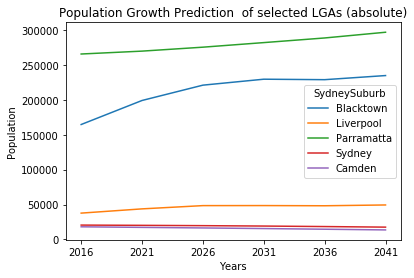

In [19]:

#population growth prediction in absolute tems--show that graphically 
df_popTrend_LineChart = df_popTrend.drop(['%Increase/Decrease'], axis=1)
df_popTrend_LineChart = df_popTrend_LineChart.set_index('SydneySuburb')

#df_popTrend_PopChart = df_popTrend_PopChart.iloc[0:3]
df_popTrend_LineChart=df_popTrend_LineChart.transpose()

#df_popTrend_PopChart.index = df_popTrend_PopChart.index.map(int) # let's change the index values of df_CI to type integer for plotting
df_popTrend_LineChart.plot(kind='line')
plt.title('Population Growth Prediction  of selected LGAs (absolute)')
plt.ylabel('Population')
plt.xlabel('Years')
plt.show()


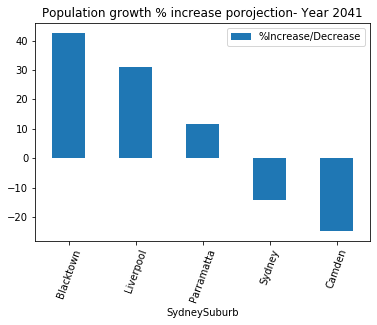

In [20]:


# Population growth in %

df_popTrend.plot.bar(x="SydneySuburb", y="%Increase/Decrease", rot=70, title="Population growth % increase porojection- Year 2041");

plt.show(block=True);




In [21]:
#call foursqaure api fucntion to get venues.

CLIENT_ID = 'ADSW2TSAEU0KVV1OJ4SRYEHKQ5V' #  Foursquare ID2
CLIENT_SECRET = 'XKD1X2D0TFFJX0FMB' #  Foursquare Secret2
VERSION = '20180605' # Foursquare API version
categories_url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
            
# make the GET request
results = requests.get(categories_url).json()
#saving the venue data in a file for subsequent retrieval without calling foresquare api 
with open('venue_categories.json', 'w') as f:  # writing JSON object
    json.dump(results, f)
    f.close()
#print (results)

In [22]:
# Opening previousely saved JSON file 
data = open('venue_categories.json',) 
results_data = json.load(data) 
data.close()


In [23]:
len(results_data['response']['categories'])


10

In [24]:

categories_list = []
# Let's print only the top-level categories and their IDs and also add them to categories_list

def get_categories(categories, level=0, max_level=0):    
    if level>max_level: return
    out = ''
    out += '-'*level
    for category in categories:
        print(out + category['name'] + ' (' + category['id'] + ')')
        get_categories(category['categories'], level+1, max_level)
        categories_list.append((category['name'], category['id']))

get_categories(results_data['response']['categories'], 0, 0)


Arts & Entertainment (4d4b7104d754a06370d81259)
College & University (4d4b7105d754a06372d81259)
Event (4d4b7105d754a06373d81259)
Food (4d4b7105d754a06374d81259)
Nightlife Spot (4d4b7105d754a06376d81259)
Outdoors & Recreation (4d4b7105d754a06377d81259)
Professional & Other Places (4d4b7105d754a06375d81259)
Residence (4e67e38e036454776db1fb3a)
Shop & Service (4d4b7105d754a06378d81259)
Travel & Transport (4d4b7105d754a06379d81259)


In [25]:
df_selSuburbWithLoc.head(10)


,SydneySuburb,Latitude,Longitude
0,Parramatta,-33.8136,151.0034
1,Blacktown,-33.7668,150.9053
2,Liverpool,-33.9286,150.9180
3,Camden,-34.0544,150.6958
4,Sydney,-33.8688,151.2093


In [26]:
#merge location table with selected LGA population increase(%) data
df_popTrend_location = pd.merge(df_popTrend, df_selSuburbWithLoc, on='SydneySuburb',how='inner')

#remove duplicate records
df_popTrend_location_distict =df_popTrend_location.drop_duplicates(subset='SydneySuburb',keep='last')
df_popTrend_location_distict.head(15)
df_filtered = df_popTrend_location_distict[['SydneySuburb','%Increase/Decrease','Latitude','Longitude']]
df_filtered_reindexed =df_filtered.reset_index(drop=True)
df_filtered_reindexed.head()


,SydneySuburb,%Increase/Decrease,Latitude,Longitude
0,Blacktown,42.59,-33.7668,150.9053
1,Liverpool,30.95,-33.9286,150.9180
2,Parramatta,11.74,-33.8136,151.0034
3,Sydney,-14.30,-33.8688,151.2093
4,Camden,-24.69,-34.0544,150.6958


In [27]:
      
#Create new dataframe to store venues data
df_selSuburb_Venue = df_filtered_reindexed.copy()
for c in categories_list:
    df_selSuburb_Venue[c[0]] = 0
df_selSuburb_Venue.head()


,SydneySuburb,%Increase/Decrease,Latitude,Longitude,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Blacktown,42.59,-33.7668,150.9053,0,0,0,0,0,0,0,0,0,0
1,Liverpool,30.95,-33.9286,150.9180,0,0,0,0,0,0,0,0,0,0
2,Parramatta,11.74,-33.8136,151.0034,0,0,0,0,0,0,0,0,0,0
3,Sydney,-14.30,-33.8688,151.2093,0,0,0,0,0,0,0,0,0,0
4,Camden,-24.69,-34.0544,150.6958,0,0,0,0,0,0,0,0,0,0


In [28]:
#def get_venues_count_SydSuburb(ll, radius, categoryId):
CLIENT_ID = 'ADSW2TSAEU0KVV1OJ4SRY' #  Foursquare ID2
CLIENT_SECRET = 'XKD1X2D0TFFJX0FM' #  Foursquare Secret2
VERSION = '20180605' # Foursquare API version

def get_venues_count_SydSuburb(latitude,longitude, radius, categoryId):
    explore_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION,
                latitude,
                longitude,
                radius,
                categoryId)

    # make the GET request
    return requests.get(explore_url).json()['response']['totalResults']
   
    

In [30]:
# get the venues of selected LGAs with in 5 KM radius and save them in a csv file for later reteival 
#without needing a call to foresquare api

for i, row in df_selSuburb_Venue.iterrows():
   
    for c in categories_list:        
        df_selSuburb_Venue.loc[i, c[0]] = get_venues_count_SydSuburb(df_selSuburb_Venue.Latitude.iloc[i],df_selSuburb_Venue.Longitude.iloc[i], radius=1000, categoryId=c[1])
    df_selSuburb_Venue.to_csv('df_selSuburb_Venue_reindexed_5KM.csv')

      
   

In [31]:
#Read already stored CSV--from now on this file will be called instead of calling foresquare api
df_selSuburb_Venue = pd.read_csv('df_selSuburb_Venue_reindexed_5KM.csv', index_col=0)
df_selSuburb_Venue.head()

,SydneySuburb,%Increase/Decrease,Latitude,Longitude,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Blacktown,42.59,-33.7668,150.9053,5,4,0,39,4,8,43,4,51,9
1,Liverpool,30.95,-33.9286,150.9180,5,2,0,13,6,6,9,3,16,5
2,Parramatta,11.74,-33.8136,151.0034,5,7,2,86,13,20,50,5,67,21
3,Sydney,-14.30,-33.8688,151.2093,42,62,7,146,120,100,136,24,137,133
4,Camden,-24.69,-34.0544,150.6958,5,2,0,11,5,5,7,1,7,0


In [32]:
#df_analyticalData = df_filtered = df_selSuburb_Venue[['SydneySuburb','%Increase/Decrease','Food','Outdoors & Recreation','College & University','Professional & Other Places','Shop & Service','Travel & Transport']][0:3]
#df_analyticalData.head()
df_analyticalData = df_selSuburb_Venue
df_analyticalData.head()

,SydneySuburb,%Increase/Decrease,Latitude,Longitude,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Blacktown,42.59,-33.7668,150.9053,5,4,0,39,4,8,43,4,51,9
1,Liverpool,30.95,-33.9286,150.9180,5,2,0,13,6,6,9,3,16,5
2,Parramatta,11.74,-33.8136,151.0034,5,7,2,86,13,20,50,5,67,21
3,Sydney,-14.30,-33.8688,151.2093,42,62,7,146,120,100,136,24,137,133
4,Camden,-24.69,-34.0544,150.6958,5,2,0,11,5,5,7,1,7,0


In [33]:
# calculation of total investment score: different factors have been given different
# wieghtage for example population growth has the highest weight (X10) and outdoor recretion venue has X2
df_analyticalData["%Increase/Decrease"] = 10*df_analyticalData["%Increase/Decrease"]
df_analyticalData['Travel & Transport'] = 5*df_analyticalData["Travel & Transport"]
df_analyticalData['College & University'] = 4*df_analyticalData["College & University"]
df_analyticalData['Shop & Service'] = 3*df_analyticalData["Shop & Service"]
df_analyticalData["Outdoors & Recreation"] = 2*df_analyticalData["Outdoors & Recreation"]
df_analyticalData["Professional & Other Places"] = 2*df_analyticalData["Professional & Other Places"]
df_analyticalData.head()



,SydneySuburb,%Increase/Decrease,Latitude,Longitude,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Blacktown,425.9,-33.7668,150.9053,5,16,0,39,4,16,86,4,153,45
1,Liverpool,309.5,-33.9286,150.9180,5,8,0,13,6,12,18,3,48,25
2,Parramatta,117.4,-33.8136,151.0034,5,28,2,86,13,40,100,5,201,105
3,Sydney,-143.0,-33.8688,151.2093,42,248,7,146,120,200,272,24,411,665
4,Camden,-246.9,-34.0544,150.6958,5,8,0,11,5,10,14,1,21,0


In [34]:
#add all the columns to get the total score 
sum_column = df_analyticalData['%Increase/Decrease']+df_analyticalData['Travel & Transport']+df_analyticalData['College & University']+df_analyticalData["Professional & Other Places"]+df_analyticalData["Shop & Service"]+df_analyticalData['Outdoors & Recreation']+df_analyticalData['Arts & Entertainment']+df_analyticalData['Event']+df_analyticalData['Nightlife Spot']+df_analyticalData["Residence"]

df_analyticalData['Total Points'] = sum_column
df_analyticalData = df_analyticalData.iloc[0:3]

df_analyticalData.head()




,SydneySuburb,%Increase/Decrease,Latitude,Longitude,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,Total Points
0,Blacktown,425.9,-33.7668,150.9053,5,16,0,39,4,16,86,4,153,45,754.9
1,Liverpool,309.5,-33.9286,150.9180,5,8,0,13,6,12,18,3,48,25,434.5
2,Parramatta,117.4,-33.8136,151.0034,5,28,2,86,13,40,100,5,201,105,616.4


In [ ]:
df_analyticalData_filtered = df_analyticalData[['SydneySuburb','Total Points']]
df_analyticalData_filtered.head()

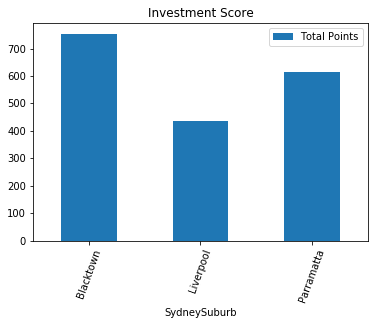

In [35]:
# bar chart showing investment score of different LGA

df_analyticalData.plot.bar(x="SydneySuburb", y="Total Points", rot=70, title="Investment Score");

plt.show(block=True);


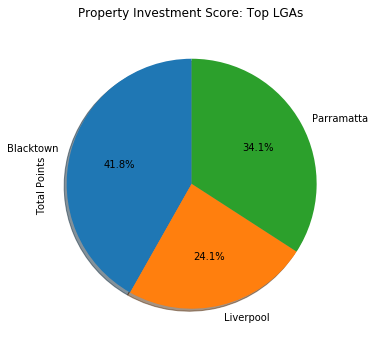

In [36]:
# showing investment score of different LGAs in % share of each LGA

df_analyticalData_pie = df_analyticalData.set_index('SydneySuburb')

df_analyticalData_pie['Total Points'].plot(kind='pie',
                            figsize=(5, 6),
                            autopct='%1.1f%%', # add in percentages
                            startangle=90,     # start angle 90° (parramatta)
                            shadow=True,       # add shadow      
                            )

plt.title('Property Investment Score: Top LGAs')
plt.axis('equal') # Sets the pie chart to look like a circle.

plt.show()

In [37]:
print ('Conclusion: from amongst the 5 selected LGAs Black Town LGA seems to be the best choice for property investment followed by Parramatta')

Conclusion: from amongst the 5 selected LGAs Black Town LGA seems to be the best choice for property investment followed by Parramatta
